<a href="https://colab.research.google.com/github/dooeun303/doo2/blob/main/20203075_%EC%9D%B4%EC%9D%80%EC%A3%BC_%EC%98%81%EC%83%81%EC%B2%98%EB%A6%AC%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 외곽선추적을 이용해서 우리나라 지도의 외곽선 따기를 해보려고 합니다
# k-means 군집화, 영역 레이블링, 외곽선 추적, 닫힘 연산을 이용했습니다.
# 사진은 네이버지도의 위성사진을 이용했습니다.

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np # NUMPY는 배열 쓸려고
import cv2
import matplotlib.pyplot as plt # 그림그리기 위함

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


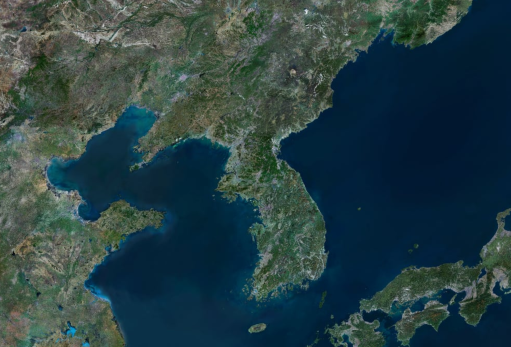

In [ ]:
# 원영상 가져오기
img = cv2.imread('/content/gdrive/My Drive/Images/map3.png')

# 크기조정
small_img = cv2.resize(img, (0,0), fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA)
cv2_imshow(small_img)

[[ 60  67  79]
 [ 77  89 102]
 [ 77  87  98]
 ...
 [ 52  30   5]
 [ 52  30   5]
 [ 52  30   4]]
(177317, 3)


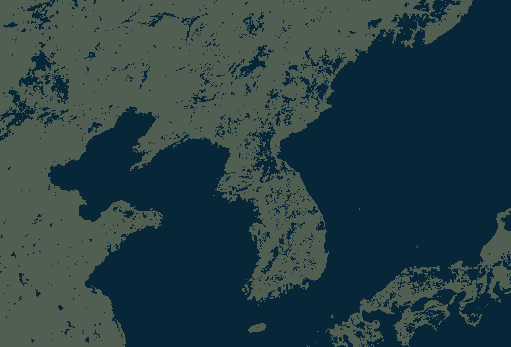

In [ ]:
# 1) k-means 군집화
# 군집화로 2개의 색으로 분류 후 이진화를 하니, 군집화 없이 이진화를 한 것 보다 경계가 명확하게 나왔음
Z = small_img.reshape((-1,3))
print(Z)
print(Z.shape)  # 전체 크기

# 기준을 정하기 (얼마나 반복할 것인가)
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# ->값의 차이가 입실론보다 작아졌다면 멈춤, 그렇지 않아도 max_iter까지 가면 멈춤

# 몇개로 나눌것인가
K = 2

# K-means 함수
ret, label, center = cv2.kmeans(Z, K, None, criteria, 20, cv2.KMEANS_PP_CENTERS)

# 출력을 위해
center = np.uint8(center)
result = center[label.flatten()]
result2 = result.reshape((small_img.shape))
small_img = np.uint8(small_img)

cv2_imshow(result2)

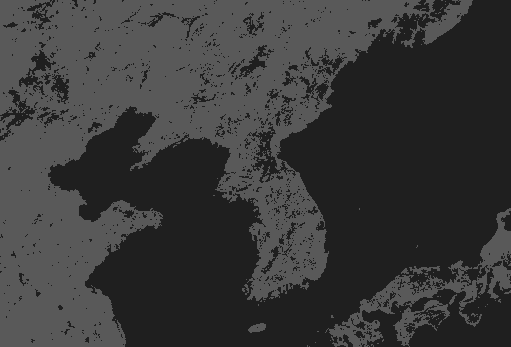

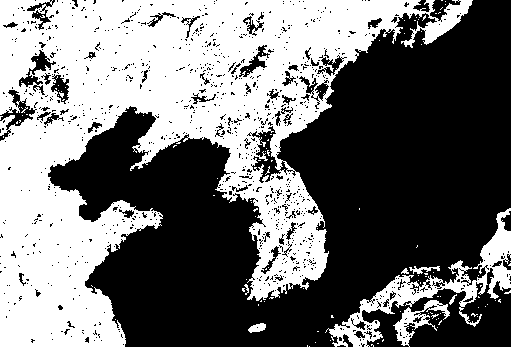

In [ ]:
# 2) 임계값으로 이진영상 만들기
# BGR 영상을 GRAY 영상으로 변경
gray_img = cv2.cvtColor(result2, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

# 임계값을 적용해서 0과 1의 이진영상으로 만들기
ret, output_img = cv2.threshold(gray_img, 50, 255, 0)
cv2_imshow(output_img)

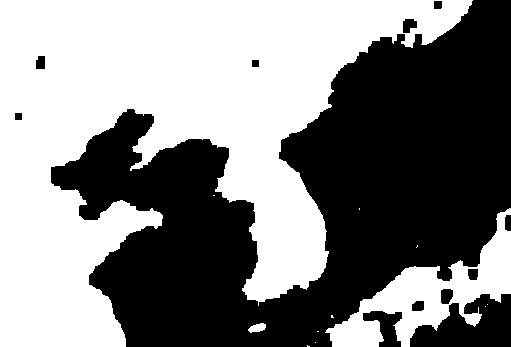

In [ ]:
# 3) 연결되지 않은 부분이 있어 닫힘연산으로 채워주기
# 처음에는 팽창연산을 사용했으나, 그렇게 하면 지도의 외곽선이 바깥으로도 커져서 외곽선이 들뜨는 현상이 있었음
# 그래서 크기는 유지하되 객체 안쪽의 비워진 부분만 채우기 위해 닫힘연산을 사용함

# 7x7 커널을 준비하기
kernel = np.ones((7,7), np.uint8)

# 닫힘연산
closing_img = cv2.morphologyEx(output_img, cv2.MORPH_CLOSE, kernel)
cv2_imshow(closing_img)

In [ ]:
# 4) 영역 레이블링 (영역을 나누기위함)
# 입력 영상에서 흰색 픽셀 영역을 레이블링하고 그 수를 카운트하기
num_labels, labels = cv2.connectedComponents(closing_img, 4)
print('number of labels: ', num_labels)

number of labels:  13


In [ ]:
# 각 영역마다 다른 색을 갖도록 조정하기
label_H = np.uint8(179*labels/np.max(labels))
blank = 255 * np.ones_like (label_H)
labeled_img = cv2.merge([label_H, blank, blank])

# 라벨을 붙인 이미지를 RGB로 바꾸기
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2RGB)

# 배경레이블은 검은색으로 설정
labeled_img[label_H == 0] = 0

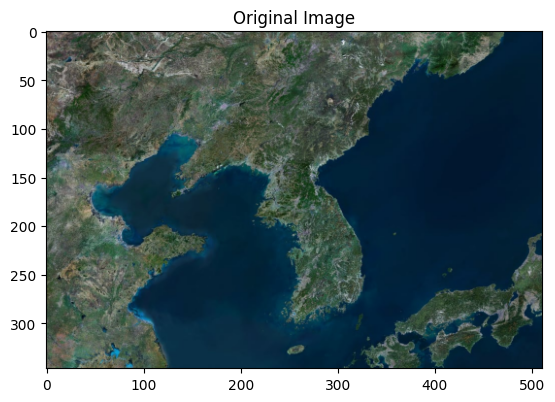

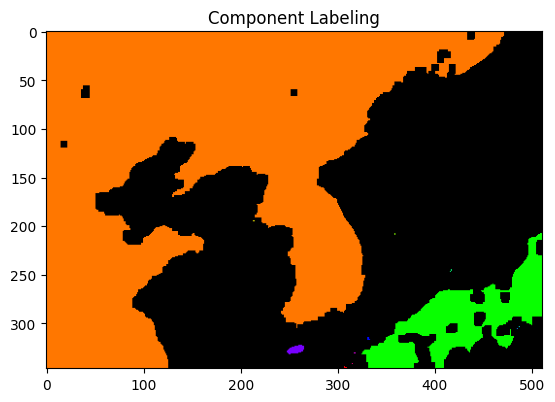

In [ ]:
# 5) 그리기
plt.imshow(cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

plt.imshow(labeled_img)
plt.title("Component Labeling")
plt.show()

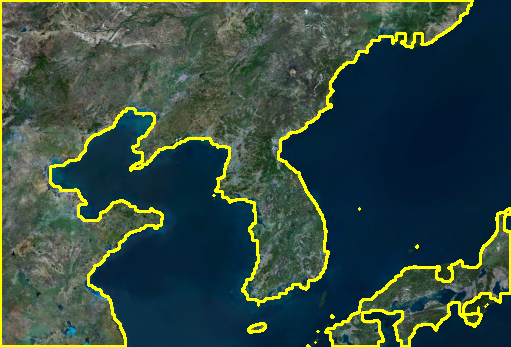

In [ ]:
# 6) 원래 영상에 외곽선을 합쳐 출력하기
contours, hierachy = cv2.findContours(closing_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
final_image = cv2.drawContours(small_img, contours, -1, (0,255,255), 2)
cv2_imshow(final_image)